<a href="https://colab.research.google.com/github/julienierwinski/Horseshoe-Housing-Project/blob/main/FINAL_726_Project_Nierwinski_Horseshoe_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries and initialize data

First, we install the needed libraries and tools (depending on environment, additional libraries may need to be installed).

Then, we upload the data and summarize key statistics of the data.

In [33]:
#Installs NumPyro with CPU support
!pip install numpyro[cpu]

In [3]:
# Data Processing and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# JAX and NumPyro Libraries
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

In [4]:
# Upload data (using Google Colab)
from google.colab import files

uploaded = files.upload()

Saving home_data.csv to home_data.csv


                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

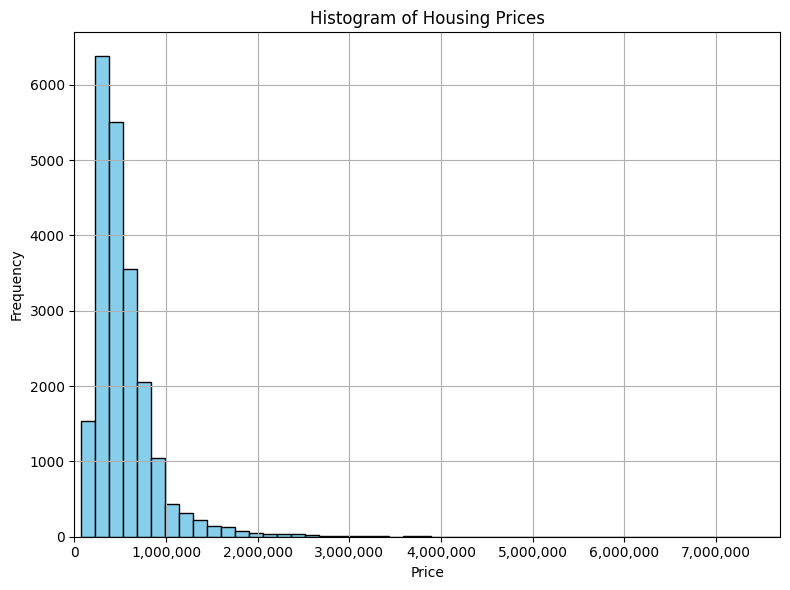

In [6]:
# Uploade the dataset
df = pd.read_csv("./home_data.csv")

# Statistical summary of dataset
print(df.describe())

# Initialize design matrix, X and the response vector, Y
X=df.drop(columns=["id","price","lat","long","date"])
Y= df["price"]

# Plot histogram of housing prices
plt.figure(figsize=(8, 6))
plt.hist(Y, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Housing Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.xlim(0, 7700000)
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.tight_layout()
plt.show()

# Data Pre-Processing
Now that data is initialized, perform pre-processing steps:


1.   Verify alldata points are valid, no missing values
2.   One-hot encode zipcodes feature
3.   Split data into training and testing data sets
4.   Normalize data sets



In [8]:
# Verify all data points and values are legitiment/valid

# Check data for any NaNs or missing values
print(df.isna().any().any())

False


In [9]:
# One-hot encode zipcode vector to be able to implement in model

# This will make a column for each zipcode and put 0's and 1's in it
X_encoded = pd.get_dummies(X, columns=["zipcode"], drop_first=True)

labels = X_encoded.columns


In [10]:
# Perform train test splits, hold out about 20% of the data and train the rest of it

# X_train + X_test = X_encoded, y_train + y_test = Y, the training sets are 80% of the data and the test sets are the 20%
X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [12]:
# Normalize all of the variables

# Initialize scaler, based on standard normal
scaler = StandardScaler()

# We only want to normalize on variables that are continuous (not one-hot encoded zipcodes)
non_zip_cols = [name for name in X_encoded.columns if "zipcode" not in name]
zipcodes_train = X_train.drop(columns=non_zip_cols)
zipcodes_test = X_test.drop(columns=non_zip_cols)

zip_cols = [name for name in X_encoded.columns if "zipcode" in name]

# Fit on training data and transform both train & test sets and is in numpy array
# Don't assume any knowledge on the test set (so there is no .fit in it) and reuse mean, std dev from training set
X_train_scaled = scaler.fit_transform(X_train.drop(columns=zip_cols))
X_test_scaled = scaler.transform(X_test.drop(columns=zip_cols))

# Normalize response vector of prices
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

new_y_train_scaled = jnp.squeeze(y_train_scaled)
new_y_test_scaled = jnp.squeeze(y_test_scaled)

# Adjoin X_trained and X_test with the one-hot zipcodes
X_train_processed = np.hstack([X_train_scaled,zipcodes_train.to_numpy()])
X_test_processed = np.hstack([X_test_scaled,zipcodes_test.to_numpy()])

# Implementing the Horseshoe Estimator and Horseshoe Results

First, we define the Horseshoe prior and then use NUTS MCMC method to generate samples.

Then, to analyze results, we extract mean of posterior coefficient values, look at its distribution, assess feature selection results, and quantify predictive performance using RMSE and adjusted R^2.

In [13]:
# Now, we implement the Horseshoe prior to ultimately generate beta values
 # (the coefficients) using the described mixture-prior

# Function that imports design matrix X and response vector of prices Y
def horseshoe_model(X,Y=None):
  # Get dimension of dataset, n= number of samples, k= number of features
  n,k= X.shape

  # Sample global shrinkage parameter
  tau = numpyro.sample("tau", dist.HalfCauchy(scale=1))

  # Sample local shrinkage parameter using C+(0,tau) - one lambda for each beta
  lambdas = numpyro.sample("lambdas", dist.HalfCauchy(scale=tau*jnp.ones(k)))

  # Coefficients for Horseshoe
  beta = numpyro.sample("beta", dist.Normal(0,lambdas))

  # Do the linear model, dot product
  dot_product = jnp.dot(X, beta)

  numpyro.sample("obs", dist.Normal(dot_product,1), obs=Y)


# Estimates the parameters of the model by performing NUTS sampling method
nuts_kernel = NUTS(horseshoe_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, Y=new_y_train_scaled, X=X_train_processed)

# Beta coefficients
posterior_coefficients = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [03:14<00:00,  7.73it/s, 127 steps of size 3.01e-02. acc. prob=0.87]


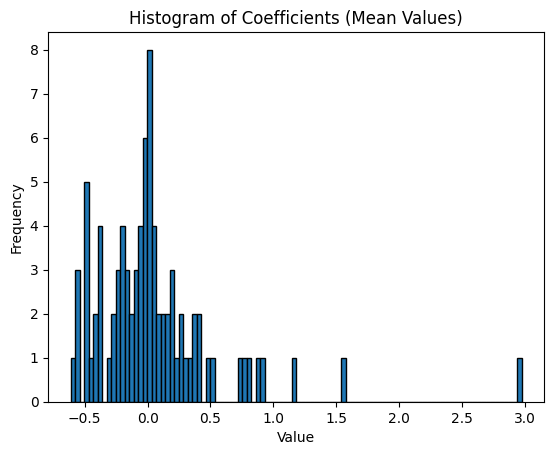

In [14]:
# Get mean for all beta coefficients
mean_betas = posterior_coefficients['beta'].mean(axis=0)

# Plot of densiy of mean_betas

plt.hist(mean_betas, bins=100, edgecolor='black')
plt.title("Histogram of Coefficients (Mean Values)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

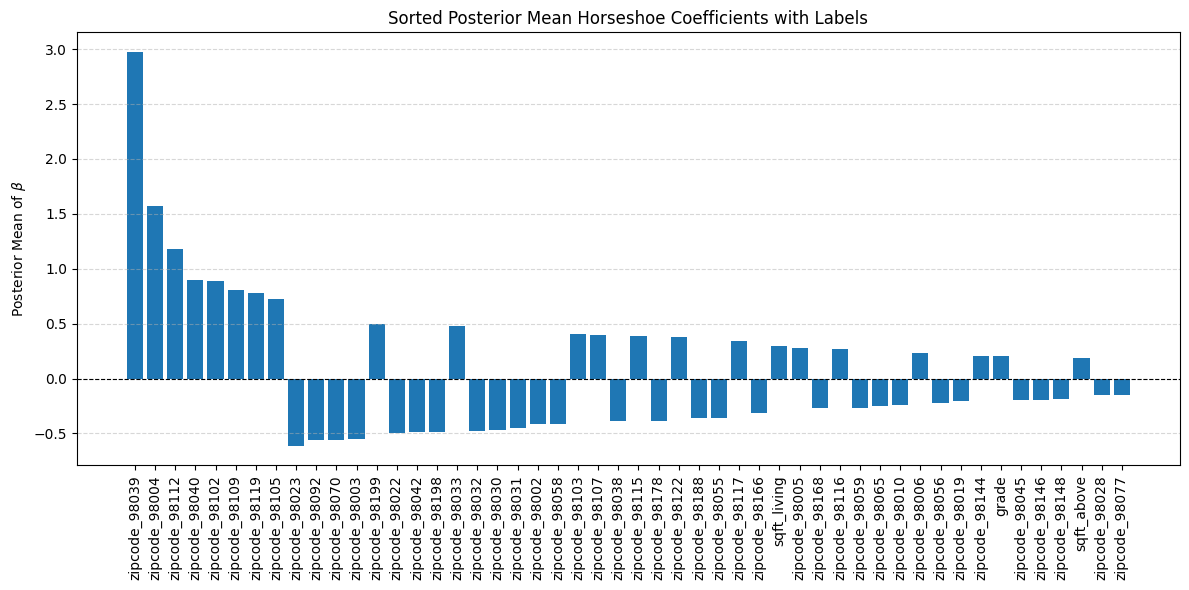

In [19]:
# Sorts from largest to smallest to find features
sorted_indices = np.argsort(-abs(mean_betas))

new_sorted_indices = sorted_indices[0:50]

new_mean_betas = mean_betas[new_sorted_indices]

# Finding the corresponding labels that are the highest contrinutors
new_labels= ['x'] * len(new_sorted_indices)

for i in range(len(new_sorted_indices)):
  new_labels[i] = labels[sorted_indices[i]]

new_labels = [labels[i] for i in new_sorted_indices]
sorted_betas = mean_betas[new_sorted_indices]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_betas)), sorted_betas, tick_label=new_labels)
plt.xticks(rotation=90)
plt.ylabel("Posterior Mean of $\\beta$")
plt.title("Sorted Posterior Mean Horseshoe Coefficients with Labels")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

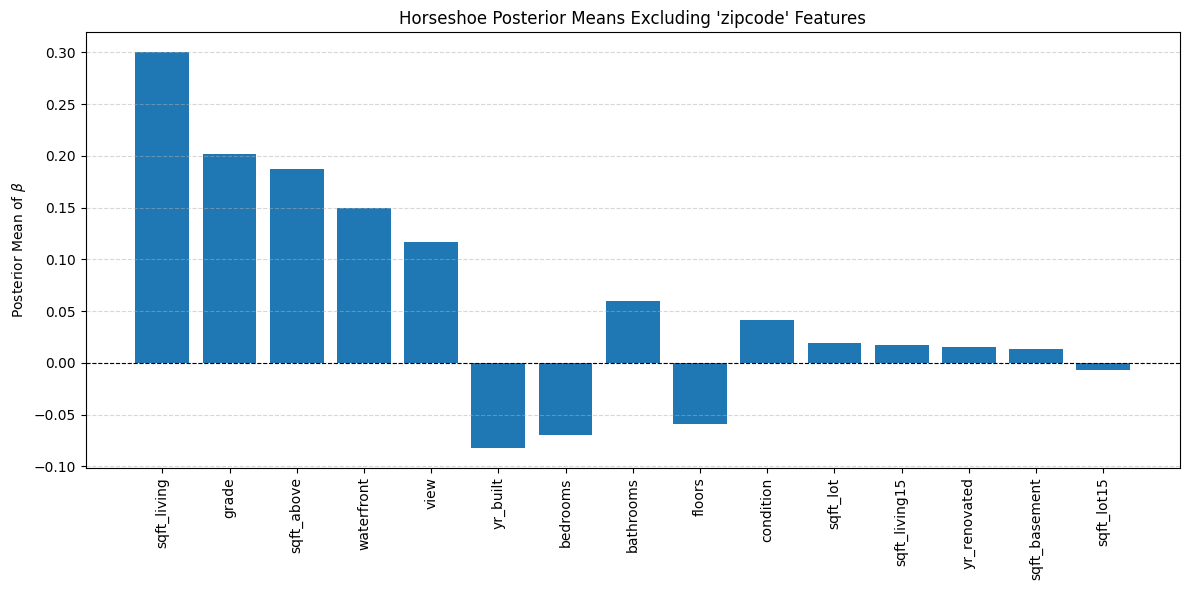

In [18]:
filtered_labels = []
filtered_betas = []

# Find top features other than zipcode
for i in sorted_indices:
    label = labels[i]
    if not label.startswith('zipcode'):
        filtered_labels.append(label)
        filtered_betas.append(mean_betas[i])

# Plot of features and coefficient values
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(filtered_betas)), filtered_betas, tick_label=filtered_labels)
plt.xticks(rotation=90)
plt.ylabel("Posterior Mean of $\\beta$")
plt.title("Horseshoe Posterior Means Excluding 'zipcode' Features")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [20]:
# To find RMSE to determine predictive performance and accuracy, multiply y_test and posterior coefficients
new_y_test = jnp.squeeze(y_test)
predictive_means =jnp.mean(X_test_processed @ posterior_coefficients['beta'].T, axis=1)

# Now, need to go convert back to actual prices
predictive_means = jnp.squeeze(scaler.inverse_transform(predictive_means.reshape(-1,1)))

rmse = jnp.sqrt(jnp.mean((predictive_means - new_y_test)**2))

print("Horseshoe RMSE:", rmse)


Horseshoe RMSE: 172714.39


In [21]:
# Calculate Adjusted R^2
n, k = X_test_processed.shape

r2_horseshoe = r2_score(new_y_test, predictive_means)

adj_r2_horseshoe = 1 - (1 - r2_horseshoe) * (n - 1) / (n - k - 1)
print("Horseshoe Adjusted R-squared:", adj_r2_horseshoe)


Horseshoe Adjusted R-squared: 0.7987685149545206


# Implement Lasso, Ridge, and Elastic Net Regression, Compare Results

First, we find the optimal hyperparameter values for Lasso, Ridge, and Elastic Net and use these values when implementing models with sklearn.

Then, execute the models and investigate feature selection amongst Lasso, Horseshoe, and Elastic Net. Then, calculate RMSE and adjusted R^2 for all methods and compare results.

In [22]:
# Find optimal alpha values for Lasso, Ridge, and Elastic Net

lasso = Lasso()
ridge = Ridge()
elasticNet = ElasticNet()

# Define the grid to search through for hyperparameter values
param_grid = {
    'alpha': np.logspace(-4, 1, 20)
}

lasso_grid = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
elasticNet_grid = GridSearchCV(elasticNet, param_grid, cv=5, scoring='neg_mean_squared_error')

lasso_grid.fit(X_train_processed, y_train_scaled)
ridge_grid.fit(X_train_processed, y_train_scaled)
elasticNet_grid.fit(X_train_processed, y_train_scaled)

# Returns the optimal parameter value for each model
best_alpha_lasso = lasso_grid.best_params_['alpha']
best_alpha_ridge = ridge_grid.best_params_['alpha']
best_alpha_elasticNet = elasticNet_grid.best_params_['alpha']

print("Best alpha for Lasso:", best_alpha_lasso)
print("Best alpha for Ridge:", best_alpha_ridge)
print("Best alpha for Elastic Net:", best_alpha_elasticNet)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.095e+01, tolerance: 1.323e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.126e+01, tolerance: 1.374e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.439e+01, tolerance: 1.383e

Best alpha for Lasso: 0.0001
Best alpha for Ridge: 0.0006158482110660267
Best alpha for Elastic Net: 0.0001


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+02, tolerance: 1.729e+00
  model = cd_fast.enet_coordinate_descent(


In [23]:

# Function to execute regression models using training and test sets
def build_eval_func(data_splits):
    X_train, X_test, y_train, y_test = data_splits

    def _eval_estimator(estimator): # function to fit an estimator on the training set and eval RMSE on the test set
        estimator.fit(X_train, y_train)
        est_preds = estimator.predict(X_test)
        est_preds = jnp.squeeze(scaler.inverse_transform(est_preds.reshape(-1,1)))
        est_rmse = mean_squared_error(y_test, est_preds)
        return est_preds, est_rmse

    return _eval_estimator

eval_estimator = build_eval_func((X_train_processed, X_test_processed, y_train_scaled, y_test))

# From above cell, alpha (lasso) = .0001
lasso = Lasso(alpha=.0001)
lasso_preds, lasso_mse = eval_estimator(lasso)

n,k= X_train_processed.shape
rmse_lasso = np.sqrt(lasso_mse)

# From above cell, alpha (ridge) = .0006
ridge = Ridge(alpha=.0006)
ridge_preds, ridge_mse = eval_estimator(ridge)
rmse_ridge = np.sqrt(ridge_mse)

# From above cell, alpha (elasticNet) = .0001
elasticNet = ElasticNet(alpha=.0001, l1_ratio=0.5)
elasticNet_preds, elasticNet_mse = eval_estimator(elasticNet)
rmse_elasticNet = np.sqrt(elasticNet_mse)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.424e+01, tolerance: 1.729e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+02, tolerance: 1.729e+00
  model = cd_fast.enet_coordinate_descent(


In [24]:
# Perform feature selection on Lasso and Elastic Net

sorted_indices_lasso = np.argsort(-abs(lasso.coef_))
sorted_indices_elasticNet = np.argsort(-abs(elasticNet.coef_))

# Find corresponding labels for indices
new_labels_lasso = [labels[i] for i in sorted_indices_lasso]
new_labels_elasticNet = [labels[i] for i in sorted_indices_elasticNet]

print("Top features for Lasso: ", new_labels_lasso)
print("Top features for Elastic Net: ", new_labels_elasticNet)

# extract zipcode features
filtered_labels_lasso = []
filtered_betas_lasso = []

filtered_labels_elasticNet = []
filtered_betas_elasticNet = []

for i in sorted_indices_lasso:
    label = new_labels_lasso[i]
    if not label.startswith('zipcode'):
        filtered_labels_lasso.append(label)
        filtered_betas_lasso.append(lasso.coef_[i])

for i in sorted_indices_elasticNet:
    label = new_labels_elasticNet[i]
    if not label.startswith('zipcode'):
        filtered_labels_elasticNet.append(label)
        filtered_betas_elasticNet.append(elasticNet.coef_[i])


Top features for Lasso:  ['zipcode_98039', 'zipcode_98004', 'zipcode_98112', 'zipcode_98102', 'zipcode_98040', 'zipcode_98109', 'zipcode_98119', 'zipcode_98105', 'zipcode_98199', 'zipcode_98033', 'zipcode_98103', 'zipcode_98107', 'zipcode_98122', 'zipcode_98115', 'zipcode_98117', 'zipcode_98005', 'zipcode_98116', 'zipcode_98006', 'zipcode_98144', 'sqft_living', 'zipcode_98136', 'zipcode_98008', 'zipcode_98007', 'zipcode_98052', 'zipcode_98177', 'zipcode_98029', 'zipcode_98125', 'zipcode_98034', 'zipcode_98053', 'zipcode_98126', 'zipcode_98023', 'zipcode_98074', 'zipcode_98118', 'zipcode_98133', 'zipcode_98070', 'zipcode_98027', 'zipcode_98092', 'zipcode_98003', 'zipcode_98075', 'zipcode_98106', 'zipcode_98072', 'zipcode_98022', 'zipcode_98024', 'zipcode_98155', 'zipcode_98042', 'grade', 'zipcode_98198', 'zipcode_98032', 'zipcode_98030', 'zipcode_98031', 'waterfront', 'zipcode_98108', 'zipcode_98028', 'zipcode_98011', 'zipcode_98002', 'view', 'zipcode_98058', 'zipcode_98077', 'zipcode_9

In [25]:
print("Top non-zipcode features Lasso: ", filtered_labels_lasso)
print("Top non-zipcode features Horseshoe: ", filtered_labels)
print("Top non-zipcodes features Elastic Net: ", filtered_labels_elasticNet)

Top non-zipcode features Lasso:  ['view', 'bedrooms', 'floors', 'yr_built', 'sqft_living', 'condition', 'bathrooms', 'waterfront', 'sqft_basement', 'sqft_lot', 'grade', 'sqft_lot15', 'yr_renovated', 'sqft_living15', 'sqft_above']
Top non-zipcode features Horseshoe:  ['sqft_living', 'grade', 'sqft_above', 'waterfront', 'view', 'yr_built', 'bedrooms', 'bathrooms', 'floors', 'condition', 'sqft_lot', 'sqft_living15', 'yr_renovated', 'sqft_basement', 'sqft_lot15']
Top non-zipcodes features Elastic Net:  ['view', 'floors', 'bedrooms', 'sqft_living', 'condition', 'bathrooms', 'yr_built', 'waterfront', 'sqft_lot', 'sqft_basement', 'sqft_above', 'sqft_lot15', 'grade', 'yr_renovated', 'sqft_living15']


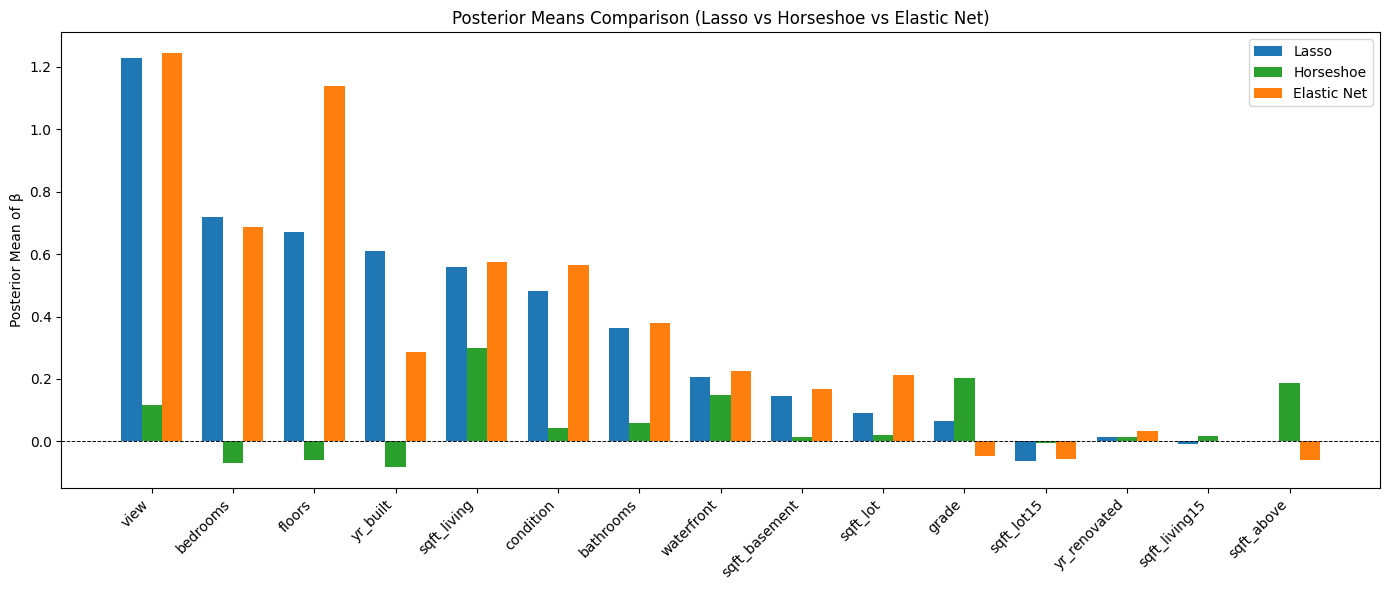

In [28]:
feature_order = [
    'view', 'bedrooms', 'floors', 'yr_built', 'sqft_living', 'condition',
    'bathrooms', 'waterfront', 'sqft_basement', 'sqft_lot', 'grade',
    'sqft_lot15', 'yr_renovated', 'sqft_living15', 'sqft_above'
]

# Make a dictionary of {feature_name: beta_value} first
lasso_dict = dict(zip(filtered_labels_lasso, filtered_betas_lasso))
horseshoe_dict = dict(zip(filtered_labels, filtered_betas))
elastic_net_dict = dict(zip(filtered_labels_elasticNet, filtered_betas_elasticNet))

# Now create Series by pulling values in the correct order
lasso_means = pd.Series([lasso_dict[feat] for feat in feature_order], index=feature_order)
horseshoe_means = pd.Series([horseshoe_dict[feat] for feat in feature_order], index=feature_order)
elastic_net_means = pd.Series([elastic_net_dict[feat] for feat in feature_order], index=feature_order)

x = np.arange(len(feature_order))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, lasso_means[feature_order], width, label='Lasso', color='tab:blue')
ax.bar(x, horseshoe_means[feature_order], width, label='Horseshoe', color='tab:green')
ax.bar(x + width, elastic_net_means[feature_order], width, label='Elastic Net', color='tab:orange')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(feature_order, rotation=45, ha='right')
ax.axhline(0, color='black', linewidth=0.7, linestyle='dashed')
ax.set_ylabel('Posterior Mean of β')
ax.set_title("Posterior Means Comparison (Lasso vs Horseshoe vs Elastic Net)")
ax.legend()

plt.tight_layout()
plt.show()

Lasso RMSE: 171304.65287317795
Ridge RMSE: 171011.6047524261
ElasticNet RMSE: 171311.628653749
Horseshoe RMSE: 172714.39


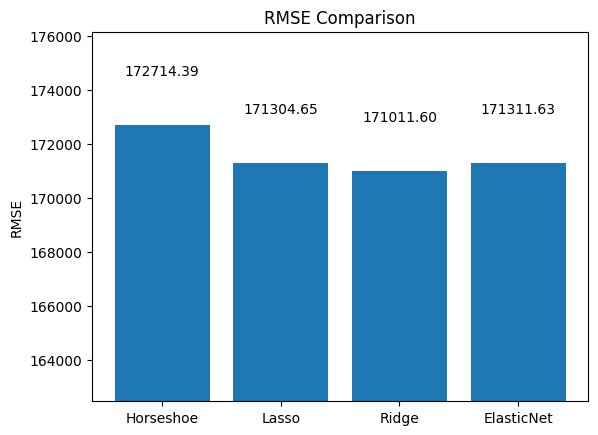

In [29]:
# Compare RMSE

print("Lasso RMSE:", rmse_lasso)
print("Ridge RMSE:", rmse_ridge)
print("ElasticNet RMSE:", rmse_elasticNet)
print("Horseshoe RMSE:", rmse)

# Plot of all the RMSE
methods = ['Horseshoe', 'Lasso', 'Ridge', 'ElasticNet']
rmse_values = [rmse, rmse_lasso, rmse_ridge, rmse_elasticNet]

plt.bar(methods, rmse_values)
plt.ylabel("RMSE")
plt.title("RMSE Comparison")
plt.ylim(min(rmse_values) * 0.95, max(rmse_values) * 1.02)
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.01 * max(rmse_values), f"{value:.2f}", ha='center', va='bottom')
plt.show()

Lasso Adjusted R-squared: 0.7492936886593686
Ridge Adjusted R-squared: 0.7520819510806616
Elastic Net Adjusted R-squared: 0.7491608401018324
Horseshoe Adjusted R-squared: 0.7987685149545206


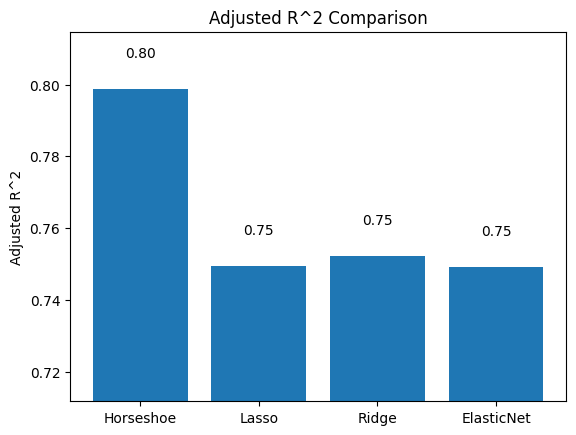

In [32]:
# Compare Adjusted R^2

#Calculate R^2
r2_lasso = r2_score(lasso_preds, y_test)
r2_ridge = r2_score(ridge_preds, y_test)
r2_elasticNet = r2_score(elasticNet_preds, y_test)

n,k= X_train_processed.shape

# Adjusted R^2
adj_r2_lasso = 1 - (1 - r2_lasso) * (n - 1) / (n - k - 1)
adj_r2_ridge = 1 - (1 - r2_ridge) * (n - 1) / (n - k - 1)
adj_r2_elasticNet = 1 - (1 - r2_elasticNet) * (n - 1) / (n - k - 1)

print("Lasso Adjusted R-squared:", adj_r2_lasso)
print("Ridge Adjusted R-squared:", adj_r2_ridge)
print("Elastic Net Adjusted R-squared:", adj_r2_elasticNet)
print("Horseshoe Adjusted R-squared:", adj_r2_horseshoe)

# Plot of all the adjusted R^2

methods = ['Horseshoe', 'Lasso', 'Ridge', 'ElasticNet']
r2_values = [adj_r2_horseshoe, adj_r2_lasso, adj_r2_ridge, adj_r2_elasticNet]

plt.bar(methods, r2_values)
plt.ylabel("Adjusted R^2")
plt.title("Adjusted R^2 Comparison")
plt.ylim(min(r2_values) * 0.95, max(r2_values) * 1.02)
for i, value in enumerate(r2_values):
    plt.text(i, value + 0.01 * max(r2_values), f"{value:.2f}", ha='center', va='bottom')
plt.show()